This tutorial assumes that you have access to a Kubernetes cluster. Like the ones provided by Google or Amazon, for example. The next thing you need to do is to build a Docker container for your application. I have found that most online resource don't explain it adequately in the context we need it so we will outline the needed steps here.

First thing you need is a Dockerfile that instructs what steps need to be taken to set-up the environment for your software, building or installing the software etc. Here is the Dockerfile we made for EasyVVUQ. Yours will look different but I hope you will see that it is fairly straightforward.

In [ ]:
!cat kubernetes/Dockerfile

You need to register for an account [DockerHub](https://hub.docker.com/). Or if you don't want your Docker image to be publicly accessible you need to look into private registries, for example [here](https://cloud.google.com/container-registry/docs/quickstart). Then you need to build your container, login to DockerHub and push the image. After that it will usually be accessible to run from your Kubernetes cluster.

```docker build -t user/imagename:tag .```

```docker login```

```docker push user/imagename:tag```

In order for the code below to work we need to have a valid ```~/.kube/config``` file. Details will differ based on your provider, but for example for Google Cloud we can do it as follows.

In [ ]:
!gcloud container clusters create easyvvuq

In [1]:
import easyvvuq as uq
import chaospy as cp
import matplotlib.pyplot as plt

In [2]:
params = {
    "S0": {"type": "float", "default": 997}, 
    "I0": {"type": "float", "default": 3}, 
    "beta": {"type": "float", "default": 0.2}, 
    "gamma": {"type": "float", "default": 0.04, "min": 0.0, "max": 1.0},
    "iterations": {"type": "integer", "default": 100},
    "outfile": {"type": "string", "default": "output.csv"}
}

In [3]:
encoder = uq.encoders.GenericEncoder(template_fname='sir.template', delimiter='$', target_filename='input.json')
decoder = uq.decoders.SimpleCSV(target_filename='output.csv', output_columns=['I'])

In [4]:
campaign = uq.Campaign(name='sir', params=params, encoder=encoder, decoder=decoder)

In [5]:
vary = {
    "beta": cp.Uniform(0.15, 0.25),
    "gamma": cp.Normal(0.04, 0.01),
}

In [6]:
campaign.set_sampler(uq.sampling.PCESampler(vary=vary, polynomial_order=5))

In [7]:
execution = campaign.sample_and_apply(
    action=uq.actions.ExecuteKubernetes(
        "orbitfold/easyvvuq:latest",
        "/EasyVVUQ/tutorials/sir /config/input.json && cat output.csv",
        ['input.json'], 'output.csv'), batch_size=8).start()

In [11]:
execution.progress()

{'ready': 0, 'active': 0, 'finished': 36, 'failed': 0}

In [12]:
result = campaign.analyse(qoi_cols=['I'])

<AxesSubplot:xlabel='t', ylabel='First Order Sobol Index'>

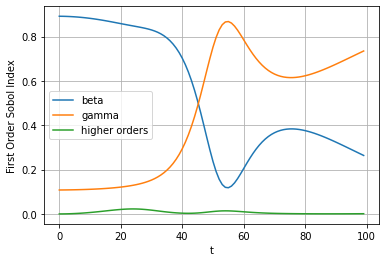

In [13]:
result.plot_sobols_first('I', xlabel='t')

<AxesSubplot:xlabel='t', ylabel='I'>

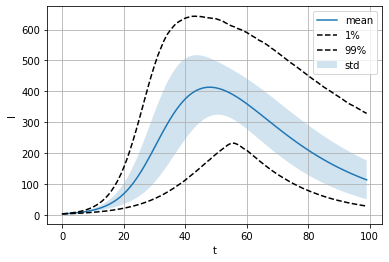

In [14]:
result.plot_moments('I', xlabel='t')